In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import sklearn

In the following we will import the data for the currency pair EURGBP (resolution of 1-min OHLC data):

In [2]:
# importing data from file, omitting the volume data which is not reliable for Forex (as oposed to stocks)
dfEURGBP = pd.read_csv("EURGBP_FT3.csv",usecols = ['<DTYYYYMMDD>','<TICKER>', '<TIME>','<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>'])
#giving more significant names to the columns to work with
d = {'<TICKER>':'Symbol','<TIME>':'Time','<OPEN>':'Open','<HIGH>':'High','<LOW>':'Low','<CLOSE>':'Close'}
dfEURGBP.rename(columns = d , inplace = True)
dfEURGBP.rename(columns = {'<DTYYYYMMDD>':'Date'}, inplace = True)
dfEURGBP.head()

,Symbol,Date,Time,Open,High,Low,Close
0,EURGBP,20090102,2100,0.9551,0.9551,0.9550,0.9550
1,EURGBP,20090104,2300,0.9545,0.9546,0.9545,0.9546
2,EURGBP,20090104,2301,0.9545,0.9545,0.9542,0.9543
3,EURGBP,20090104,2302,0.9544,0.9547,0.9544,0.9546
4,EURGBP,20090104,2303,0.9545,0.9548,0.9545,0.9548


In the following we will convert the 1-min data to daily data which will serve as the basis for our later analysis (prediciton models as well as benchmark simulation):

In [3]:
#creating a data frame that will hold the daily data
start_date = dt.datetime.strptime(str(dfEURGBP.iloc[0]['Date']), '%Y%m%d')
end_date = dt.datetime.strptime(str(dfEURGBP.iloc[len(dfEURGBP.index) - 1]['Date']), '%Y%m%d')
dates = pd.date_range(start_date, end_date)
dfDailyEURGBP = pd.DataFrame(index = dates)
dfDailyEURGBP['Open'] = np.nan
dfDailyEURGBP['High'] = np.nan
dfDailyEURGBP['Low'] = np.nan
dfDailyEURGBP['Close'] = np.nan

In [4]:
#calculating the daily OHLC prices using the groupby method for daily grouping. The daily high and low are the max and min prices
#of the high and low columns per group (that is, per day) and the daily open and close are the average of the first and last
# 5 minutes of each day, respectively
dfGrouped = dfEURGBP.groupby('Date')
for name, group in dfGrouped:
    dailyOpenPrice =  group.head()['Open'].mean() #first 5 min of each day
    dailyClosePrice = group.tail()['Close'].mean() #last 5 min of each day
    dailyHighPrice = group.max()['High'] #the max of the high data (minute resolution) 
    dailyLowPrice = group.min()['Low'] #the min of the low data 9minute resolution)
    convertedInd = np.datetime64(dt.datetime.strptime(str(name), '%Y%m%d'))
    dfDailyEURGBP.ix[convertedInd, 'Open'] = dailyOpenPrice
    dfDailyEURGBP.ix[convertedInd, 'Close'] = dailyClosePrice
    dfDailyEURGBP.ix[convertedInd, 'High'] = dailyHighPrice
    dfDailyEURGBP.ix[convertedInd, 'Low'] = dailyLowPrice
#the dates that correspond to weekends will still contain NaN, and so are dropped from the dataframe
dfDailyEURGBP.dropna(inplace = True)

In the following we calculate the categories of return for each prediction period (1 day, 3 days, 7 days and 14 days) based on the data. This will serve as the true result. we need this tep since we are treating this problem as a classification problem and thus need the output variable (return at the end of the period) to be discrete and not continous.
At the end of the process we will have a modified dataframe with additional columns for each return category: 

In [5]:
#prediction periods
periods = [1, 3, 7, 14]
#here we will calculate the true return category for each date for the different periods.
for p in periods:
    s_direction = "return_direction_only_{}_days".format(p)
    returnsDirectionOnly = []
    for element in dfDailyEURGBP.index.values:
        # for each date we calculate the return category for p days in the future
        location = dfDailyEURGBP.index.get_loc(element)
        currentPrice = dfDailyEURGBP.ix[element]['Close']
        futurePriceLocation = location + p
        if futurePriceLocation < len(dfDailyEURGBP):
            futurePrice = dfDailyEURGBP.iloc[futurePriceLocation]['Close']
            currentReturn = ((futurePrice - currentPrice) / currentPrice) * 100
            if currentReturn < 0:
                returnsDirectionOnly.append(0)
            elif currentReturn >= 0:
                returnsDirectionOnly.append(1)
            else:
                print "Sanity check - we can't be here"
                break
    # for each period we won't naturally have values for the return category for the last 1,3,7 and 14 days respectively
    for i in range(len(dfDailyEURGBP) - len(returnsDirectionOnly)):
        returnsDirectionOnly.append(np.nan)
    dfDailyEURGBP[s_direction] = pd.Series(returnsDirectionOnly, index = dfDailyEURGBP.index.values)

Now we can proceed to calculating the benchmark values for each legitimate starting date:

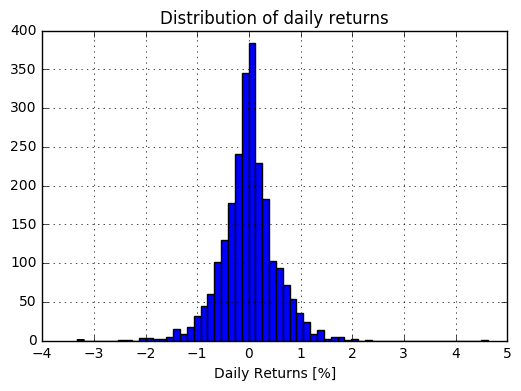

In [6]:
#first, let us have a quick look at the histogram of the daily returns to eye ball it for normality.
%matplotlib inline
import matplotlib.pyplot as plt
dfDailyEURGBPchange = (dfDailyEURGBP['Close'].pct_change(1)) * 100
dfDailyEURGBPchange.hist(bins = 60) #seems normal for our purposes
plt.xlabel("Daily Returns [%]")
plt.title("Distribution of daily returns")
plt.savefig("DailyReturnDistribution")
#now we will use for our simulation the daily values
dfDailyEURGBPchange = (dfDailyEURGBP['Close'].pct_change(1)) 
dailyChangeMean = dfDailyEURGBPchange.mean()
dailyChangeStd = dfDailyEURGBPchange.std()

From the above figure it can be seem that the different distributions are rougly normal (not perfect but close enough) for the benchmark purposes. We thus at the end calculated the daily average and std for the simulation purposes. We will now create some helper functions that will allow us to get the benchmark category prediction for each legitimate starting price.

*** Helper function for calculating the output class: ***

In [7]:
#this is a small helper function for calculating return category
#it has the additional capacity (for future work) to calculate multi-class return categories and not just binary
def calculateCategory(returnValue, directionOnly = True):
    if directionOnly == False:
        if returnValue < -5:
            return("A")
        elif returnValue >= -5 and returnValue < -1:
            return("B")
        elif returnValue >= -1 and returnValue < 0:
            return("C")
        elif returnValue >= 0 and returnValue < 1:
            return("D")
        elif returnValue >= 1 and returnValue < 5:
            return("E")
        elif returnValue >= 5:
            return("F")
        else:
            print "Sanity check - we can't be here"
    else:
        if returnValue < 0:
            return 0
        else:
            return 1

***The function to calculate the benchmark values:***

In [8]:
#now we can create a function that simulate for each prediction period the banchmark prediction
#startDate should be given as an int in the form yyyymmdd and period is either 1,3,7 or 14
import numpy.random as npr
npr.seed(42)

def benchmarkCalc(startDate, period, direction = True, convert = True):
    sampleSizeSimulation = 1000  #sample size for the simulation 
    if convert:
        start = np.datetime64(dt.datetime.strptime(str(startDate), '%Y%m%d'))
    else:
        start = startDate
    startClosePrice = dfDailyEURGBP.ix[start, ['Close']]['Close']
    simulatedPrices = []
    categories = []
    for i in range(sampleSizeSimulation):
        randomValues = npr.normal(dailyChangeMean, dailyChangeStd, period)
        tmpPrice = startClosePrice
        for i in range(period):
            tmpPrice = tmpPrice + randomValues[i] * tmpPrice
        simulatedPrices.append(tmpPrice)
    #the mean of the simulated values is considered the benchmark price prediction
    benchmarkPriceResult = pd.Series(simulatedPrices).mean()
    #now we need to calculate the corresponding category
    returnBenchmark = ((benchmarkPriceResult - startClosePrice) / startClosePrice) * 100
    returnBenchmarkCategory = calculateCategory(returnBenchmark, directionOnly = direction)
    return returnBenchmarkCategory


In [9]:
#we add it to the dataframe and it will serve as our output columns
for index, row in dfDailyEURGBP.iterrows():
    dfDailyEURGBP.loc[index, "Benchmark_1_day_DirectionOnly"] = benchmarkCalc(index, 1, direction = True, convert = False)
    dfDailyEURGBP.loc[index, "Benchmark_3_day_DirectionOnly"] = benchmarkCalc(index, 3, direction = True, convert = False)
    dfDailyEURGBP.loc[index, "Benchmark_7_day_DirectionOnly"] = benchmarkCalc(index, 7, direction = True, convert = False)
    dfDailyEURGBP.loc[index, "Benchmark_14_day_DirectionOnly"] = benchmarkCalc(index, 14, direction = True, convert = False)

Now we are going to move forward and build classification models using decision trees, SVM and neural networks. The first thing we will do is to build some indicators out of the raw price data that will serve as features/predictors/X's. We do this in order to work with well known and used indicators that are widely used across Forex trading.
The indicators we will build are:

SMA(20)/Close: The Simple Moving Average for the last 20 days of the close price divided by the Close price for the current day. This was adopted from the course "Machine Learning For Trading" where Prof. Bulch talks about this feature so I thought I will include it.

ATR(20): Average True Range. Developed by J. Welles Wilder, the Average True Range (ATR) is an indicator that measures volatility.It is important to remember that ATR does not provide an indication of price direction, just volatility. The window of calculation is again the last 20 days.

Bollinger Bands: Developed by John Bollinger, Bollinger Bands® are volatility bands placed above and below a moving average. Volatility is based on the standard deviation, which changes as volatility increases and decreases. Bollinger Bands can be used to determine the strength of the trend. Again, we will use 20 days window.

Daily Return: A very common feature to consider is the return of the current day, just after close. This will be a discrete feature with the same categories as the output variables.

These are our features and later on we will use them in the training and testing of our different models.


In [10]:
#daily return
pd.options.mode.chained_assignment = None
dfDailyEURGBP["DailyReturn"] = dfDailyEURGBP['Close'].pct_change(1) * 100
dfDailyEURGBP["DailyReturn"][0] = 0
dfDailyEURGBP["DailyReturnCategory"] = dfDailyEURGBP["DailyReturn"].apply(calculateCategory)

In [11]:
#SMA(20)/Close
def calculateSMA(data, lookbackPeriod = 20):
    title = "SMA({})/Close".format(str(lookbackPeriod))
    #data[title] = pd.rolling_mean(data['Close'], lookbackPeriod) / data['Close']
    data[title] = data['Close'].rolling(window = lookbackPeriod).mean() / data['Close']
    return data
dfDailyEURGBP = calculateSMA(dfDailyEURGBP)

In [12]:
#ATR
def averageTRvalues(TR, lookbackPeriod = 20):
    ans = []
    for i in range(lookbackPeriod - 1):
        ans.append(np.nan)
    ans.append(TR[0:lookbackPeriod].mean())
    for i in range(lookbackPeriod, TR.size):
        ans.append((ans[i - 1] * (lookbackPeriod - 1) + TR[i]) / lookbackPeriod)
    return ans
def calculateATR(data, lookbackPeriod = 20):
    title = "ATR({})".format(str(lookbackPeriod))
    data["TR_1"] = (data['High'] - data['Low']).abs() #HIGH - CLOSE for the current day
    data["TR_2"] = (data['High'] - data['Close'].shift(1)).abs() #Today's HIGH - yesterday's CLOSE
    data["TR_3"] = (data['Close'].shift(1) - data['Low']).abs() #Yesterday's CLOSE - today's LOW
    data["TR"] = data[["TR_1", "TR_2", "TR_3"]].max(axis = 1) #the max of the three is the True Range value
    # now we average it to calculate the ATR.
    data[title] = pd.Series(averageTRvalues(data["TR"]), index = data.index)
    return data

dfDailyEURGBP = calculateATR(dfDailyEURGBP)

In [13]:
#Bollinger Bands. 
# here we will calculate the upper bollinger value and the lower bollinger value since the middle band is just the SMA.
def calculateBB(data,lookbackPeriod = 20, distance = 2):
    data["UpperBB"] = data['Close'].rolling(window = lookbackPeriod).mean() + data['Close'].rolling(window = lookbackPeriod).std() * distance
    data["LowerBB"] = data['Close'].rolling(window = lookbackPeriod).mean() - data['Close'].rolling(window = lookbackPeriod).std() * distance
    return data
dfDailyEURGBP = calculateBB(dfDailyEURGBP)

In [14]:
#MACD (Moving Average Convergence Divergence). It is a popular momentum indicator that computes the difference between two moving
#averages of different periods. We will use the MACD SMA with the default values of 12 and 26: 12D SMA - 26D SMA. Now, in trading
#what is actually being used is the MACD signal value which is a moving average of the above difference and this is the value
#we will use
def calculateMACD(data, fastPeriod = 12, slowPeriod = 26, signalPeriod = 9):
    data["MACDfast"] = data['Close'].rolling(window = fastPeriod).mean()
    data["MACDSlow"] = data['Close'].rolling(window = slowPeriod).mean()
    data["MACD"] = data["MACDfast"] - data["MACDSlow"]
    data["MACD_Signal"] = data["MACD"].rolling(window = signalPeriod).mean()
    return data
dfDailyEURGBP = calculateMACD(dfDailyEURGBP)


In [15]:
#RSI (Relative Strength Index). This indicator is a momentum oscillator that relates to zones of oversold and overbought of 
# a financial instrument. It is given by: RSI = 100 - 100 / (1 + RS), where RS = average gain / average loss, and we will use 
# the daily return as our gain or loss for a period window of 14 for calculating this average.


def calculateRSI(data, averagePeriod = 14):
    #first we need to create the gain and losses vectors
    gain = data["DailyReturn"].copy()
    gain[gain < 0 ] = 0 #for the average gain we only need the sma of the positive values
    loss = data["DailyReturn"].copy()
    loss[loss > 0] = 0 #same thing in the other direction
    loss = loss.abs()
    RS = gain.rolling(window = averagePeriod).mean() / loss.rolling(window = averagePeriod).mean()
    data["RSI"] = 100 - 100 / (1 + RS)
    return data

dfDailyEURGBP = calculateRSI(dfDailyEURGBP)  

In [16]:
# now we need to clean our dataset a little bit in order to get rid of all the "helper" columns and create a training
# and testing set
dfDailyEURGBPClean = dfDailyEURGBP.dropna()

# helper function to index the dataframe easily
def intToDate(d):
    return np.datetime64(dt.datetime.strptime(str(d),'%Y%m%d')) #date should be in the form YYYYMMDD as an int 

# we will, for starters, train on the the data set since the beginning until the end of 2014 and use 2015 and 2016
# as the test set.
trainData = dfDailyEURGBPClean.loc[:intToDate(20151231)] # we use all the data up to 2016 for training
testData = dfDailyEURGBPClean.loc[intToDate(20160101):] # the data of 2016 is used for testing

print "We have {} days in our training data ".format(trainData.shape[0])
print "We have {} days in our testing data ".format(testData.shape[0])




We have 2137 days in our training data 
We have 220 days in our testing data 


In [17]:
from sklearn.metrics import accuracy_score
# we will run our benchmark function for 2016, which is the testing set
BenchmarkData = dfDailyEURGBPClean.loc[intToDate(20160101):]
print "--------------------------------------------------------------------------------"
print "Below are the results for the test period (year 2016) of the benchmark function:"
print "--------------------------------------------------------------------------------"
print "return direction only for 1 day prediction:"
print accuracy_score(BenchmarkData['return_direction_only_1_days'], BenchmarkData['Benchmark_1_day_DirectionOnly'])
print "return direction only for 3 day prediction:"
print accuracy_score(BenchmarkData['return_direction_only_3_days'], BenchmarkData['Benchmark_3_day_DirectionOnly'])
print "return direction only for 7 day prediction:"
print accuracy_score(BenchmarkData['return_direction_only_7_days'], BenchmarkData['Benchmark_7_day_DirectionOnly'])
print "return direction only for 14 day prediction:"
print accuracy_score(BenchmarkData['return_direction_only_14_days'], BenchmarkData['Benchmark_14_day_DirectionOnly'])

--------------------------------------------------------------------------------
Below are the results for the test period (year 2016) of the benchmark function:
--------------------------------------------------------------------------------
return direction only for 1 day prediction:
0.531818181818
return direction only for 3 day prediction:
0.513636363636
return direction only for 7 day prediction:
0.436363636364
return direction only for 14 day prediction:
0.427272727273


In [18]:
#now we can import the relevant functionality from sklearn
from sklearn.tree import DecisionTreeClassifier
# the two main changes I would like to make to the default settings are for the criterion (entropy instead of ginni) and 
# min_samples_split for 1% (half a percent) since this gives roughly a little bit over two weeks and less days will be too
# volatile according with my experience to "trust" the split. We can always fine tune it later.
features = ['DailyReturn', 'SMA(20)/Close', 'ATR(20)', 'UpperBB', 'LowerBB', 'MACD_Signal', 'RSI']
outputs = ['return_direction_only_1_days','return_direction_only_3_days','return_direction_only_7_days','return_direction_only_14_days']
#here we rapidly get a taste for the decision tree model out of the box using information gain 
clf = DecisionTreeClassifier(criterion = "entropy", random_state = 23)
#training set
X = trainData[features]
Y = trainData[['return_direction_only_14_days']] #we run it for the two weeks direction prediction
clf.fit(X,Y)
#testing set
X_test = testData[features]
Y_test = testData[['return_direction_only_14_days']]
print "the score on the test set year of our 'out of the box' model (return direction only for 14 day prediction):"
print clf.score(X_test, Y_test)
print "the score when we first predict and then calling accuracy_score is:"
y_pred = clf.predict(X_test)
print accuracy_score(y_pred, Y_test)

the score on the test set year of our 'out of the box' model (return direction only for 14 day prediction):
0.413636363636
the score when we first predict and then calling accuracy_score is:
0.413636363636


As can be seen from the result we do not "win" the benchmark model by using out-of-the-box decision tree. Some tuning is required. We need to do some cross-validation and parameter fine tuning. For that we need to remember that the correct way to split the data for cross-validation is by using a time series split, available for us in sklearn as TimeSeriesSplit.
Also, I have decided for the next algos to run the GridSearch from the beginning instead of going through a trial of the model out of the box due to the above results.

In [19]:
#this is the data set used for fine tuning 
X_crossValidation = trainData[features]
Y_crossValidation = trainData[outputs]
#this is the data set used for testing the final model, after fine tuning has been conducted (totally unseen by the models)
X_testCrossValidation = testData[features]
Y_testCrossValidation = testData[outputs]

In [20]:
#Now we will conduct cross-validation
from sklearn.model_selection import TimeSeriesSplit #for time series split avoiding look-ahead bias
from sklearn.model_selection import GridSearchCV #for fine-tuning main parameters
tree = DecisionTreeClassifier(random_state = 23) # our estimator to be optimized with respect to its parameters (subset of them)
# here are the parameter grid to search upon
p_grid = {"criterion":["entropy", "gini"], "max_depth":[5,6,7,8,9,10], "min_samples_split":[6,8,10,12,14],"min_samples_leaf":[5,6,7,8,9,10]}
# dictionaries to hold the results - best model score (on the cross-validation) for each prediction period, params of these best
# models and the accuracy score of these models on the unseen test data
bestModelScores_DecisionTree = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
bestModelParams_DecisionTree = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
bestScoreOnTestSet_DecisionTree = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
#running the fine tuning
for period in [1,3,7,14]:
    # split the data into numSplits "folds" and set the ground for parameter tuning
    cvSplit = TimeSeriesSplit(n_splits = 8)
    clf = GridSearchCV(estimator = tree, param_grid = p_grid, cv = cvSplit, scoring = 'accuracy')
    # extracting the current output for cv tuning and testing
    currentOutput = 'return_direction_only_{}_days'.format(str(period)) 
    Y_current = Y_crossValidation[currentOutput] 
    Y_currentTest = Y_testCrossValidation[currentOutput]
    # run the search
    clf.fit(X_crossValidation, Y_current)
    # run the test
    currentBestScoreTestSet = clf.score(X_testCrossValidation, Y_currentTest)
    # store the results in the appropriate dictionary
    bestModelScores_DecisionTree["{}_day".format(str(period))].append(clf.best_score_)
    bestModelParams_DecisionTree["{}_day".format(str(period))].append(clf.best_params_)
    bestScoreOnTestSet_DecisionTree["{}_day".format(str(period))].append(currentBestScoreTestSet)

print bestScoreOnTestSet_DecisionTree

{'7_day': [0.51818181818181819], '14_day': [0.4681818181818182], '3_day': [0.44545454545454544], '1_day': [0.48636363636363639]}


In [21]:
print bestModelParams_DecisionTree

{'7_day': [{'min_samples_split': 6, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 7}], '14_day': [{'min_samples_split': 6, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 7}], '3_day': [{'min_samples_split': 6, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 6}], '1_day': [{'min_samples_split': 6, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 9}]}


Now we can try to use a second algorithm to classify our binary results - SVM. Before that, I realized it would be more efficient to write a function that runs the fine tuning and just call it for each algorithm with the appropriate setup:

In [22]:
def fineTuneParameters(bestScores, bestParams, bestScoreTestSet, model, pGrid):
    for period in [1,3,7,14]:
        numSplits = 8 # chose one value for simplicity
        cvSplit = TimeSeriesSplit(n_splits = numSplits)
        clf = GridSearchCV(estimator = model, param_grid = pGrid, cv = cvSplit, scoring = 'accuracy')
        currentOutput = 'return_direction_only_{}_days'.format(str(period)) 
        Y_current = Y_crossValidation[currentOutput] 
        Y_currentTest = Y_testCrossValidation[currentOutput]
        clf.fit(X_crossValidation, Y_current)
        currentBestScoreTestSet = clf.score(X_testCrossValidation, Y_currentTest)
        bestScores["{}_day".format(str(period))].append(clf.best_score_)
        bestParams["{}_day".format(str(period))].append(clf.best_params_)
        bestScoreTestSet["{}_day".format(str(period))].append(currentBestScoreTestSet)

In [23]:
# Here we start with the SVM part.
from sklearn.svm import SVC
#Since I don't have any preference based on my domain knowkedge to a specific kernel giving the technical indicators we are
#using(the features), we will try and test a large suite of tuning parameters, including kernel functions.

#let us start with a simple linear kernel tuning the value of the regularization parameter C
bestModelScores_SVM_linear = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
bestModelParams_SVM_linear = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
bestScoreOnTestSet_SVM_linear = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
svmLinear = SVC(kernel = 'linear', random_state = 23)
p_grid_linear = {'C':[0.1, 0.5, 1.0, 5.0, 15.0]}
fineTuneParameters(bestModelScores_SVM_linear, bestModelParams_SVM_linear, bestScoreOnTestSet_SVM_linear, svmLinear, p_grid_linear)

print bestScoreOnTestSet_SVM_linear

{'7_day': [0.38636363636363635], '14_day': [0.35909090909090907], '3_day': [0.52727272727272723], '1_day': [0.51818181818181819]}


In [24]:
# now we will try rbf kernel

bestModelScores_SVM_rbf = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
bestModelParams_SVM_rbf = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
bestScoreOnTestSet_SVM_rbf = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
svmRBF = SVC(kernel = "rbf", random_state = 23)
p_grid_rbf = {"C":[0.1, 0.5, 1.0, 5.0, 15.0], "gamma":[0.001,0.01,0.05,0.1,0.15]}
fineTuneParameters(bestModelScores_SVM_rbf,bestModelParams_SVM_rbf,bestScoreOnTestSet_SVM_rbf,svmRBF,p_grid_rbf)

print bestScoreOnTestSet_SVM_rbf

{'7_day': [0.44545454545454544], '14_day': [0.35909090909090907], '3_day': [0.49545454545454548], '1_day': [0.5]}


In [25]:
# now we will try sigmoid kernel
bestModelScores_SVM_sigmoid = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
bestModelParams_SVM_sigmoid = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
bestScoreOnTestSet_SVM_sigmoid = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
svmSigmoid = SVC(kernel = "sigmoid", random_state = 23)
p_grid_sigmoid = {"C":[0.1, 0.5, 1.0, 5.0, 15.0], "gamma":[0.001,0.01,0.05,0.1,0.15]} #same as rbf
fineTuneParameters(bestModelScores_SVM_sigmoid,bestModelParams_SVM_sigmoid,bestScoreOnTestSet_SVM_sigmoid,svmSigmoid,p_grid_sigmoid)
#svmSigmoid.fit(X_crossValidation,Y_crossValidation['return_direction_only_1_days'])
#svmSigmoid.score(X_testCrossValidation,Y_testCrossValidation['return_direction_only_1_days'])
print bestModelScores_SVM_sigmoid
print bestScoreOnTestSet_SVM_sigmoid 

{'7_day': [0.52531645569620256], '14_day': [0.51371308016877637], '3_day': [0.495253164556962], '1_day': [0.50263713080168781]}
{'7_day': [0.50909090909090904], '14_day': [0.35909090909090907], '3_day': [0.53181818181818186], '1_day': [0.48636363636363639]}


In [26]:
# neural networks - we will use a multi-layer perceptron classifier from sklearn
from sklearn.neural_network import MLPClassifier
bestScoreOnTestSet_NN = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
for p in [1,3,7,14]:
    for method in ["logistic", "tanh", "relu"]:
        currentOutput = "return_direction_only_{}_days".format(str(p))
        NNmodel = MLPClassifier(solver = 'lbfgs', shuffle = False, random_state = 23, activation = method)
        NNmodel.fit(X_crossValidation, Y_crossValidation[currentOutput])
        bestScoreOnTestSet_NN["{}_day".format(str(p))].append(NNmodel.score(X_testCrossValidation,Y_testCrossValidation[currentOutput]))
print bestScoreOnTestSet_NN

{'7_day': [0.50454545454545452, 0.47727272727272729, 0.50454545454545452], '14_day': [0.40454545454545454, 0.42727272727272725, 0.49545454545454548], '3_day': [0.44545454545454544, 0.45909090909090911, 0.47727272727272729], '1_day': [0.51818181818181819, 0.47272727272727272, 0.53181818181818186]}


In [27]:
# kNN
from sklearn.neighbors import KNeighborsClassifier

bestModelScores_kNN = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
bestModelParams_kNN = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}
bestScoreOnTestSet_kNN = {"1_day":[], "3_day":[], "7_day":[], "14_day":[]}

knnModel = KNeighborsClassifier()
p_grid_knn = {"n_neighbors":[3,5,10,15,20,25,30], "weights":["distance", "uniform"]}

fineTuneParameters(bestModelScores_kNN,bestModelParams_kNN,bestScoreOnTestSet_kNN,knnModel,p_grid_knn)

In [28]:
print bestScoreOnTestSet_kNN['3_day']
print bestModelParams_kNN['3_day']

[0.55454545454545456]
[{'n_neighbors': 20, 'weights': 'uniform'}]


In [29]:
# in light of the previous results I have decided to use an ensemble algorithm and adaboost seems to be a good choice. 
from sklearn.ensemble import AdaBoostClassifier
# we will use a decision tree with the best parameters we found earlier to use in our boost algo.
# the parameter varies a bit for the different prediction horizons so we will run AdAboost for each horizon apart

In [30]:
#1-day direction prediction
results_1_day = []
for numEstimators in range(10, 201, 2):
    bdt = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split = 6, criterion = 'entropy', max_depth = 6, min_samples_leaf = 9), n_estimators = numEstimators, random_state = 23)
    bdt.fit(X_crossValidation,Y_crossValidation['return_direction_only_1_days'])
    scr = bdt.score(X_testCrossValidation,Y_testCrossValidation['return_direction_only_1_days'])
    results_1_day.append(scr)
print max(results_1_day)
print results_1_day.index(max(results_1_day))

0.545454545455
3


In [31]:
#3-day direction prediction
results_3_day = []
for numEstimators in range(10, 201, 10):
    bdt = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split = 6, criterion = 'entropy', max_depth = 10, min_samples_leaf = 6), n_estimators = numEstimators, random_state = 23)
    bdt.fit(X_crossValidation,Y_crossValidation['return_direction_only_3_days'])
    scr = bdt.score(X_testCrossValidation,Y_testCrossValidation['return_direction_only_3_days'])
    results_3_day.append(scr)
print max(results_3_day)

0.490909090909


In [32]:
#7-day direction prediction
results_7_day = []
for numEstimators in range(10, 201, 10):
    bdt = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split = 6, criterion = 'entropy', max_depth = 6, min_samples_leaf = 7), n_estimators = numEstimators, random_state = 23)
    bdt.fit(X_crossValidation,Y_crossValidation['return_direction_only_7_days'])
    scr = bdt.score(X_testCrossValidation,Y_testCrossValidation['return_direction_only_7_days'])
    results_7_day.append(scr)
print max(results_7_day)

0.490909090909


In [33]:
results_14_day = []
for numEstimators in range(10, 201, 10):
    bdt = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split = 6, criterion = 'entropy', max_depth = 6, min_samples_leaf = 7), n_estimators = numEstimators, random_state = 23)
    bdt.fit(X_crossValidation,Y_crossValidation['return_direction_only_14_days'])
    scr = bdt.score(X_testCrossValidation,Y_testCrossValidation['return_direction_only_14_days'])
    results_14_day.append(scr)
print max(results_14_day)

0.436363636364


**All the code found below this point was written for agumenting the report and as extra/additioanl analysis**

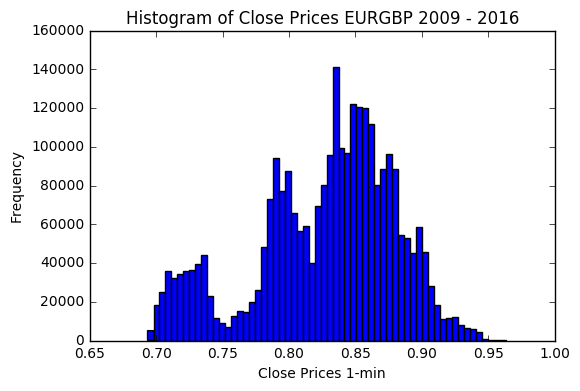

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(dfEURGBP['Close'], bins = 60)
plt.xlabel("Close Prices 1-min")
plt.ylabel("Frequency")
plt.title("Histogram of Close Prices EURGBP 2009 - 2016")
plt.savefig('rawPriceHist.png')

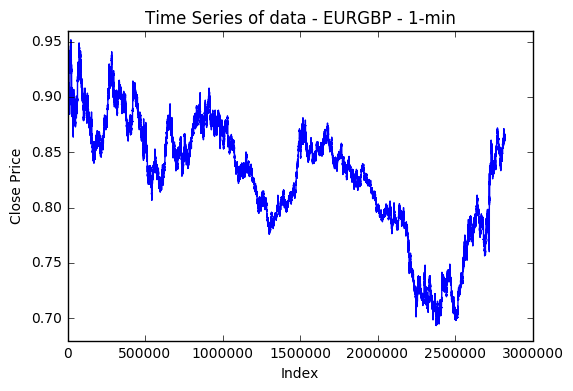

In [35]:
plt.plot(dfEURGBP['Close'], linewidth = 1.0)
axes = plt.gca()
axes.set_ylim([0.68,0.96])
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.title("Time Series of data - EURGBP - 1-min")
plt.savefig('rawPriceTimeSeries.png')

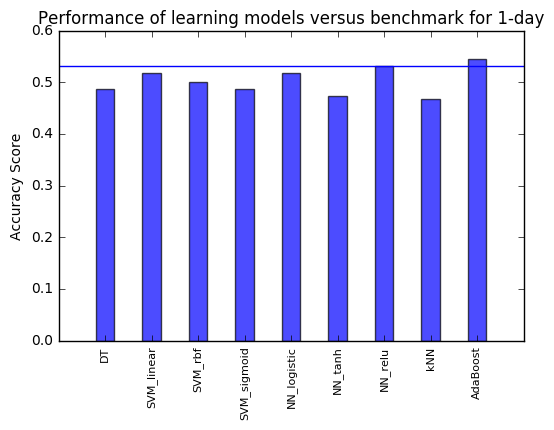

In [36]:
#1-day
benchmark_result_1_day = accuracy_score(BenchmarkData['return_direction_only_1_days'], BenchmarkData['Benchmark_1_day_DirectionOnly'])
DT = bestScoreOnTestSet_DecisionTree['1_day'][0]
SVM_linear = bestScoreOnTestSet_SVM_linear['1_day'][0]
SVM_rbf = bestScoreOnTestSet_SVM_rbf['1_day'][0]
SVM_sigmoid = bestScoreOnTestSet_SVM_sigmoid['1_day'][0]
NN_logistic = bestScoreOnTestSet_NN['1_day'][0]
NN_tanh = bestScoreOnTestSet_NN['1_day'][1]
NN_relu = bestScoreOnTestSet_NN['1_day'][2]
kNN = bestScoreOnTestSet_kNN['1_day'][0]
AdaBoost = max(results_1_day)
categories = ['DT','SVM_linear','SVM_rbf','SVM_sigmoid','NN_logistic','NN_tanh','NN_relu','kNN','AdaBoost']
y_pos = np.arange(len(categories))
scores = [DT, SVM_linear, SVM_rbf, SVM_sigmoid, NN_logistic, NN_tanh, NN_relu, kNN, AdaBoost]
plt.bar(y_pos, scores, align = 'center', alpha = 0.7, width = 0.4)
plt.xticks(y_pos, categories, fontsize = 8, rotation='vertical')
plt.axhline(y = benchmark_result_1_day)
plt.ylabel('Accuracy Score')
plt.title('Performance of learning models versus benchmark for 1-day')
plt.savefig('PerformanceModels_1_day.png')





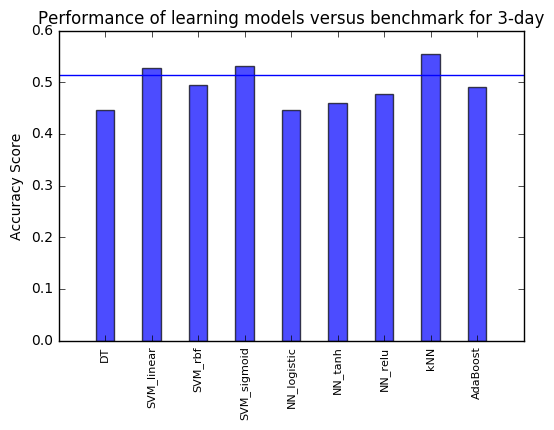

In [37]:
#3-day
benchmark_result = accuracy_score(BenchmarkData['return_direction_only_3_days'], BenchmarkData['Benchmark_3_day_DirectionOnly'])
DT = bestScoreOnTestSet_DecisionTree['3_day'][0]
SVM_linear = bestScoreOnTestSet_SVM_linear['3_day'][0]
SVM_rbf = bestScoreOnTestSet_SVM_rbf['3_day'][0]
SVM_sigmoid = bestScoreOnTestSet_SVM_sigmoid['3_day'][0]
NN_logistic = bestScoreOnTestSet_NN['3_day'][0]
NN_tanh = bestScoreOnTestSet_NN['3_day'][1]
NN_relu = bestScoreOnTestSet_NN['3_day'][2]
kNN = bestScoreOnTestSet_kNN['3_day'][0]
AdaBoost = max(results_3_day)
categories = ['DT','SVM_linear','SVM_rbf','SVM_sigmoid','NN_logistic','NN_tanh','NN_relu','kNN','AdaBoost']
y_pos = np.arange(len(categories))
scores = [DT, SVM_linear, SVM_rbf, SVM_sigmoid, NN_logistic, NN_tanh, NN_relu, kNN, AdaBoost]
plt.bar(y_pos, scores, align = 'center', alpha = 0.7, width = 0.4)
plt.xticks(y_pos, categories, fontsize = 8, rotation='vertical')
plt.axhline(y = benchmark_result)
plt.ylabel('Accuracy Score')
plt.title('Performance of learning models versus benchmark for 3-day')
plt.savefig('PerformanceModels_3_day.png')

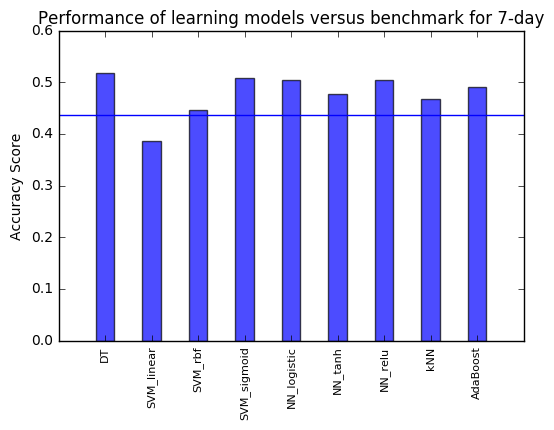

In [38]:
#7-day
benchmark_result = accuracy_score(BenchmarkData['return_direction_only_7_days'], BenchmarkData['Benchmark_7_day_DirectionOnly'])
DT = bestScoreOnTestSet_DecisionTree['7_day'][0]
SVM_linear = bestScoreOnTestSet_SVM_linear['7_day'][0]
SVM_rbf = bestScoreOnTestSet_SVM_rbf['7_day'][0]
SVM_sigmoid = bestScoreOnTestSet_SVM_sigmoid['7_day'][0]
NN_logistic = bestScoreOnTestSet_NN['7_day'][0]
NN_tanh = bestScoreOnTestSet_NN['7_day'][1]
NN_relu = bestScoreOnTestSet_NN['7_day'][2]
kNN = bestScoreOnTestSet_kNN['7_day'][0]
AdaBoost = max(results_7_day)
categories = ['DT','SVM_linear','SVM_rbf','SVM_sigmoid','NN_logistic','NN_tanh','NN_relu','kNN','AdaBoost']
y_pos = np.arange(len(categories))
scores = [DT, SVM_linear, SVM_rbf, SVM_sigmoid, NN_logistic, NN_tanh, NN_relu, kNN, AdaBoost]
plt.bar(y_pos, scores, align = 'center', alpha = 0.7, width = 0.4)
plt.xticks(y_pos, categories, fontsize = 8, rotation='vertical')
plt.axhline(y = benchmark_result)
plt.ylabel('Accuracy Score')
plt.title('Performance of learning models versus benchmark for 7-day')
plt.savefig('PerformanceModels_7_day.png')

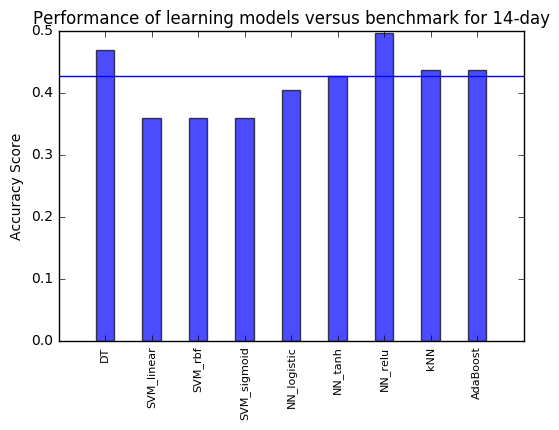

In [39]:
#14-day
benchmark_result = accuracy_score(BenchmarkData['return_direction_only_14_days'], BenchmarkData['Benchmark_14_day_DirectionOnly'])
DT = bestScoreOnTestSet_DecisionTree['14_day'][0]
SVM_linear = bestScoreOnTestSet_SVM_linear['14_day'][0]
SVM_rbf = bestScoreOnTestSet_SVM_rbf['14_day'][0]
SVM_sigmoid = bestScoreOnTestSet_SVM_sigmoid['14_day'][0]
NN_logistic = bestScoreOnTestSet_NN['14_day'][0]
NN_tanh = bestScoreOnTestSet_NN['14_day'][1]
NN_relu = bestScoreOnTestSet_NN['14_day'][2]
kNN = bestScoreOnTestSet_kNN['14_day'][0]
AdaBoost = max(results_14_day)
categories = ['DT','SVM_linear','SVM_rbf','SVM_sigmoid','NN_logistic','NN_tanh','NN_relu','kNN','AdaBoost']
y_pos = np.arange(len(categories))
scores = [DT, SVM_linear, SVM_rbf, SVM_sigmoid, NN_logistic, NN_tanh, NN_relu, kNN, AdaBoost]
plt.bar(y_pos, scores, align = 'center', alpha = 0.7, width = 0.4)
plt.xticks(y_pos, categories, fontsize = 8, rotation='vertical')
plt.axhline(y = benchmark_result)
plt.ylabel('Accuracy Score')
plt.title('Performance of learning models versus benchmark for 14-day')
plt.savefig('PerformanceModels_14_day.png')